# <center>Multiclass Vegetable Classification Using Transfer Learning</center>
<center><img src= "https://p4.wallpaperbetter.com/wallpaper/667/254/333/vegetables-fruit-still-life-food-wallpaper-preview.jpg" alt ="Titanic" style='width:500px;'></center><br>

<h1><center> Idea behind using Transfer learning </center></h1> 

- <h2> Instead of training a deep network from scratch, we can actually take a pre-trained network and use it for a different task as learning of a new task relies on the previously learned tasks. </h2><br>
- <h2> Assisting in image analysis and classification tasks including object detection with good accuracy.</h2><br>
- <h2> We will use InceptionV3 which is a network already trained on more than a million images from the ImageNet database </h2>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from PIL import Image 
from PIL import ImageEnhance
from skimage.io import imread
import matplotlib.pyplot as plt

import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout

K.clear_session()

# <span style="color:blue"><b>1. Loading the dataset</b></span>
<hr>
<h2> Let's define the path to base directories used in the project </h2>

In [2]:
dataset=r'C:\Users\Snehal Thakur\PycharmProjects\FoodImageRecipeGeneration\dataset\foodImages'

train_folder = os.path.join(dataset,"train")
test_folder = os.path.join(dataset,"validation")
validation_folder = os.path.join(dataset,"test")

<h2>Counting number of images in a folder. (test set in our case)</h2>

In [3]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(test_folder))

There are 28 files in cheesecake
There are 28 files in french_fries
There are 28 files in hamburger
There are 28 files in hot_dog
There are 28 files in pizza


<h2> As evident, Dataset is well balanced with each class containing : </h2>
    
- <h3> 1000 images for training set. </h3>
    
- <h3> 200 images for test set. </h3>

# <span style="color:blue"><b>2. Image Processing</b></span>
<hr>
<h2> The goal of image processing is improvement of pictorial information for human interpretation. Basic manipulation and filtering can lead to increased understanding for feature extraction as well. </h2><br>
<h3><b><span style="color:green">Here we can select any vegetable of our choice and a random image from the class is displayed with comparison to a processed image.</span></b></h3>


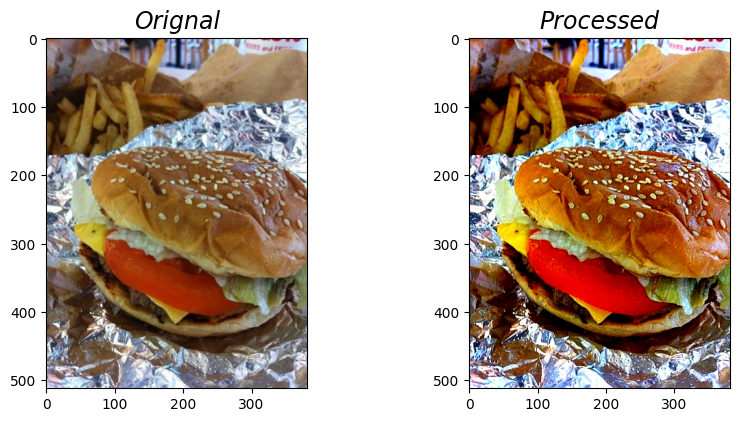

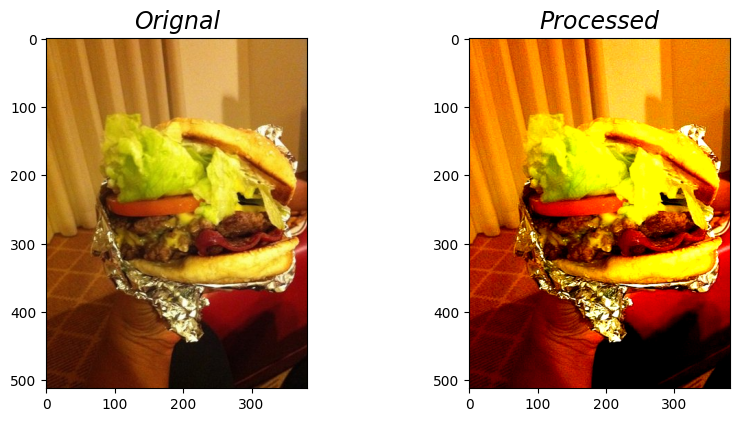

In [5]:
image_folder="hamburger"  # The vegetable you want to display
number_of_images=2       # Number of images to display

def Preprocess():
    j=1
    for i in range(number_of_images):
    
        folder = os.path.join(test_folder,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(10,10))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)
        
        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1
        
Preprocess()

<h3> We increased the color saturation, contrast and finally sharpened the image for drawing texture and viewer focus. The image after processing looks appealing and brighter</h3>

# <span style="color:blue"><b> 3. Data Visualization (EDA)</b></span>
<hr>
<h2> We can start exploring the dataset and visualize any class label <i>(for instance, Capsicum)</i>. You can choose any vegetable to visualize the images of that class. Changing rows and columns variable also results in different format positioning of matplotlib. </h2>

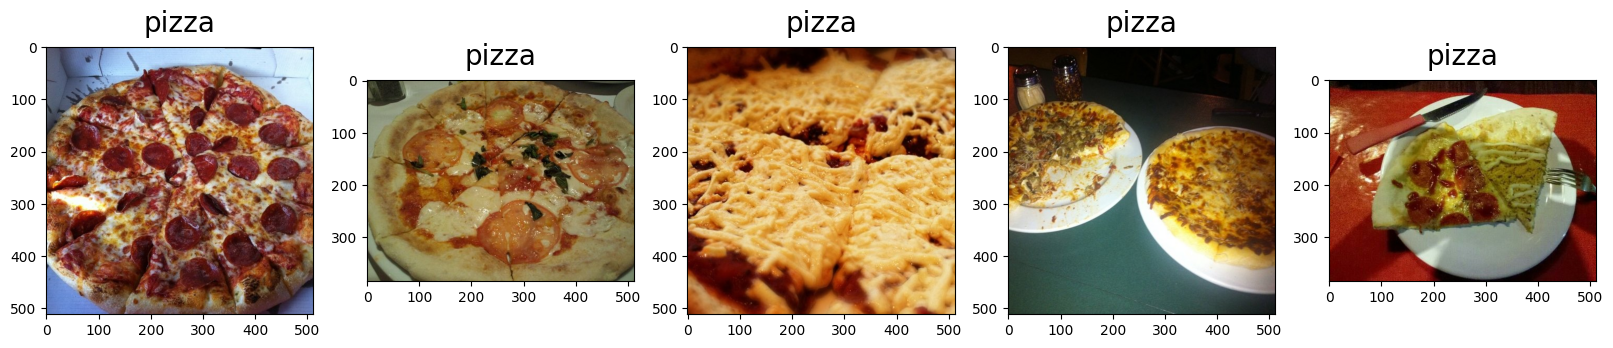

In [7]:
select_vegetable="pizza"
rows,columns = 1,5

display_folder=os.path.join(train_folder,select_vegetable)
total_images=rows*columns
fig=plt.figure(1, figsize=(20, 10))

for i,j in enumerate(os.listdir(display_folder)):      
    
    img = plt.imread(os.path.join(train_folder,select_vegetable,j))
    fig=plt.subplot(rows, columns, i+1)
    fig.set_title(select_vegetable, pad = 11, size=20)
    plt.imshow(img)
    
    if i==total_images-1:
        break

<h2> Now let's visualize the whole dataset by picking a random image from each class inside training dataset. </h2>

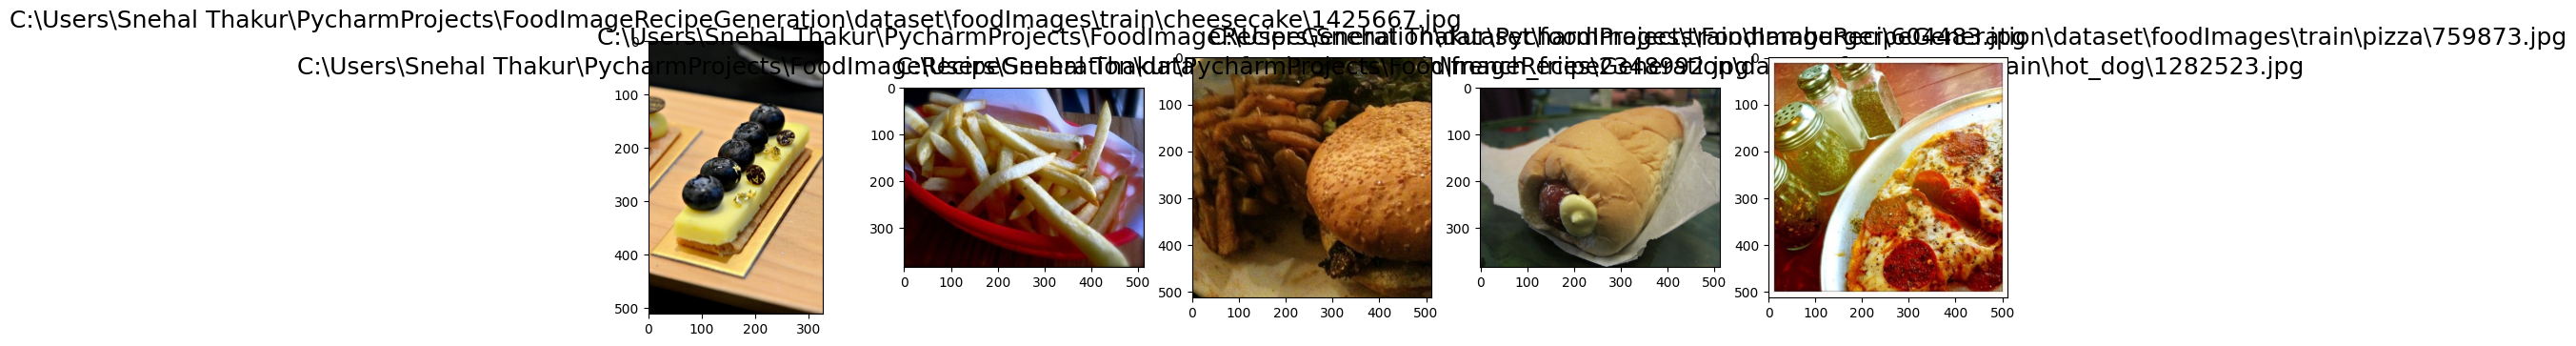

In [9]:
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder,food_folder,food_selected))
                                     
fig=plt.figure(1, figsize=(15, 10))

for subplot,image_ in enumerate(images):
    category=image_.split('/')[-1]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(3, 5, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    
plt.tight_layout()

<span style="font-size:18px;color:green"><b>There are 15 vegetables (output classes) and one random image from each class helps in determining basic outlook of dataset and what picture quality along with different metric are visible. So far, So Good! </b></span>

# <span style="color:blue"><b>4. Model Building</b></span>
<hr>
<h2> Let's start building the transfer learning network to train our model using <u>InceptionV3</u>. </h2>

In [11]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [22]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(5, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['sparse_categorical_crossentropy']
)

# <span style="color:blue"><b>5. Model Training</b></span>
<hr>

In [23]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_folder,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
    test_folder, 
    target_size = (224, 224),
    batch_size = 64, 
    class_mode = 'categorical')

Found 4500 images belonging to 5 classes.
Found 140 images belonging to 5 classes.


In [24]:
class_map = training_set.class_indices
class_map

{'cheesecake': 0, 'french_fries': 1, 'hamburger': 2, 'hot_dog': 3, 'pizza': 4}

In [25]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\traitlets\config\application.py", line 985, in launch_instance
      app.start()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Snehal Thakur\AppData\Local\Temp\ipykernel_11880\379773180.py", line 1, in <module>
      r = model.fit(
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\losses.py", line 2098, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\Public\DataScience\envs\food-image-recipe-generation\lib\site-packages\keras\backend.py", line 5633, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [64,5] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_48148]

## Saving the Model

In [11]:
model.save('model_inceptionV3_epoch5.h5')

## Accuracy and Loss Curves

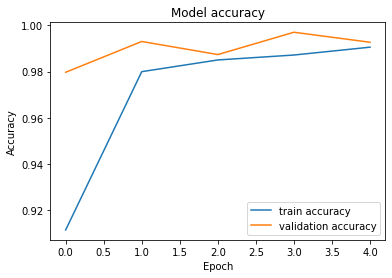

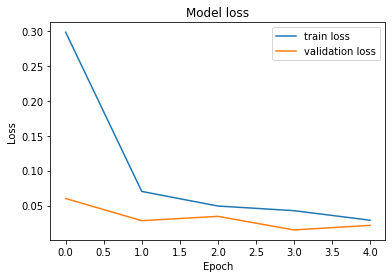

In [12]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

## Model Layers

In [13]:
print("Total layers in the model : ",len(model.layers),"\n")

layers = [layer.output for layer in model.layers[0:]]
layer_names = []
for layer in model.layers[0:]: 
    layer_names.append(layer.name)
    
print("First layer : ", layer_names[0])
print("InceptionV3 layers : Layer 2 to Layer 311")
print("Our fine tuned layers : ", layer_names[311:314])
print("Final Layer : ", layer_names[314])


Total layers in the model :  315 

First layer :  input_1
InceptionV3 layers : Layer 2 to Layer 311
Our fine tuned layers :  ['global_average_pooling2d', 'dense', 'dropout']
Final Layer :  dense_1


# <b><span style="color:blue">6. Predictions</span></b>
<hr>
<h2> Loading the model </h2>

In [14]:
K.clear_session()
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


## Testing the model on validation set

In [15]:
validation_data_dir = '../input/vegetable-image-dataset/Vegetable Images/test'

validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 3000 images belonging to 15 classes.
Test Accuracy: 0.992


<h2> Functions to predict the output of our model

In [16]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

- <h3> Single image prediction </h3>

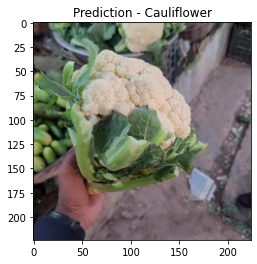

In [17]:
predict_image(os.path.join(validation_folder,'Cauliflower/1064.jpg'),model)

- <h3> Validation directory accuracy prediction </h3>

In [18]:
for i in os.listdir(validation_folder):
    predict_dir(os.path.join(validation_folder,i),model)

Accuracy for Broccoli: 0.99 (199/200)
Accuracy for Capsicum: 1.00 (200/200)
Accuracy for Bottle_Gourd: 1.00 (200/200)
Accuracy for Radish: 0.99 (199/200)
Accuracy for Tomato: 0.98 (197/200)
Accuracy for Brinjal: 0.97 (194/200)
Accuracy for Pumpkin: 0.99 (199/200)
Accuracy for Carrot: 0.99 (199/200)
Accuracy for Papaya: 1.00 (200/200)
Accuracy for Cabbage: 0.99 (199/200)
Accuracy for Bitter_Gourd: 0.99 (198/200)
Accuracy for Cauliflower: 0.98 (197/200)
Accuracy for Bean: 0.99 (199/200)
Accuracy for Cucumber: 0.99 (199/200)
Accuracy for Potato: 0.98 (197/200)


# <b><span style="color:blue">7. Evaluation</span></b>
<hr> 
<h2> Loading the model </h2>

## Confusion Matrix for evaluating the performance of our classification model.

In [19]:
def labels_confusion_matrix(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in os.listdir(folder_path):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = image.load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="turbo"
    cm_plot_labels = [i for i in range(15)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

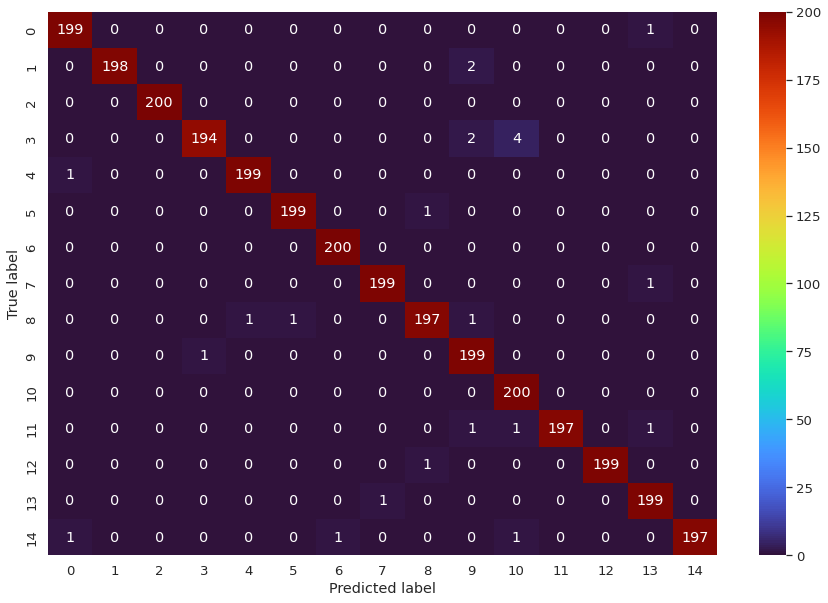

In [20]:
y_true,y_pred=labels_confusion_matrix(validation_folder)
print_confusion_matrix(y_true,y_pred)

## Visualizing all incorrect images predicted for a particular vegetable category by our classifier. 

In [21]:
def wrong_input_capture(test_category):
    
    a=os.path.basename(test_category)
    wrong_array=[]
    
    for i in os.listdir(test_category):
        
        imggg=os.path.join(test_category,i)
        
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        
        index = np.argmax(prediction)
        pred=category.get(index)
        
        if not pred==a:
            wrong_array.append((imggg,pred))
            
    return wrong_array
    
def visualize_wrong_input(images):
    
    fig=plt.figure(1, figsize=(20, 25))
    total_images=len(images)
    rows=math.ceil(float(total_images/3))
    for subplot,(image_path,predicted) in enumerate(images):
        img = plt.imread(image_path)
        fig=plt.subplot(rows, 3, subplot+1)
        fig.set_title("Predicted - {}".format(predicted), pad = 10,size=18)
        plt.imshow(img)
        
    plt.tight_layout()

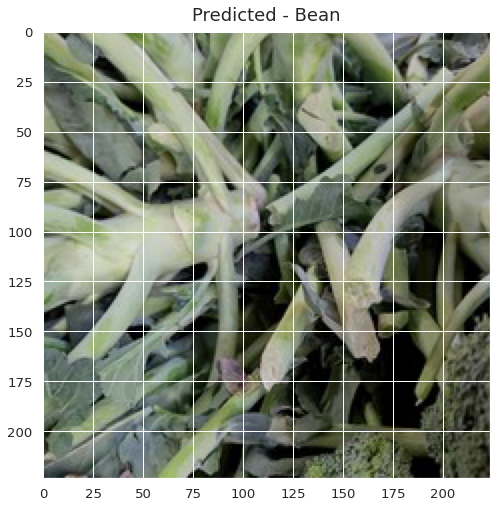

In [22]:
vegetable="Broccoli"
path=os.path.join(validation_folder,vegetable)
images= wrong_input_capture(path)
visualize_wrong_input(images)

<center><span style="font-size:21px;color:blue"><b>As you can see, the false positives are really low as we have used transfer learning which has given us good accuracy!</b></span></center>
<hr>
<h2><center>If you liked this kernel, please consider upvoting.<br>Happy Kaggling.</center></h2>

<hr>